# makeEstimation_VAEwithDG.ipynb 이후 돌리기

- 모든 폴드의 결과를 하나로 합쳐서 평균 & 표준편차를 구하고 이를 그래프로 완성함

In [4]:
# import 필요한 라이브러리
import os
from os.path import join
from natsort import natsorted
from pathlib import Path
import shutil
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [5]:
# 필요한 함수 선언
def ensure_dir(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)

In [192]:
# 필요한 함수 정의
def meanStdPlot(position,data,name):
    color_X = "#008080"##015734
    color_Y = "#4d019a"#58008f
    linewidth = 2
    
    subAJ_right = 0.5
    subAJ_top = 1.0
    subAJ_wspace = 0.5
    sub_offset= 40

    data = np.array(data).astype(float)
    print('data : ',data.shape)
    
    host = host_subplot(position, axes_class=AA.Axes)
    
    plt.subplots_adjust(right=subAJ_right,top=subAJ_top, wspace=subAJ_wspace)

    par1 = host.twinx()

    par1.axis["right"].toggle(all=True) 


    # host.set_xlim(0, 2)
    # host.set_ylim(0, 2)

    host.set_xlabel(f"Normalized Time")
    host.set_title(
    f"{name}"
    )
    # host.set_ylabel("Angle")
    # par1.set_ylabel("Angle")
    # par2.set_ylabel("Z_axis")

    p1, = host.plot(range(0,len(data[0])), data[0], linewidth=linewidth,label="True",color=color_X)
    host.fill_between(range(0,len(data[0])), data[0]+data[1],data[0]-data[1],alpha=0.2,facecolor=p1.get_color(), edgecolor=(0,0,0,.8))
    p2, = par1.plot(range(0,len(data[0])),  data[2],linewidth=linewidth, label="Pred",color=color_Y)
    par1.fill_between(range(0,len(data[0])), data[2]+data[3],data[2]-data[3],alpha=0.2,facecolor=p2.get_color(),edgecolor=(0,0,0,.8))
    
    if 'angle' in name:
        if 'X' in name:
            host.set_ylim(-55, 0)
            par1.set_ylim(-55, 0)
        elif 'Y' in name:
            host.set_ylim(-10, 10)
            par1.set_ylim(-10, 10)
        elif 'Z' in name:   
            host.set_ylim(-25, 10)
            par1.set_ylim(-25, 10)

    # elif 'moBWHT' in name:
    #     host.set_ylim(0, 4)
    #     par1.set_ylim(0, 4)
     

    host.legend()

    host.axis["left"].label.set_color(color_X)
    par1.axis["right"].label.set_color(color_Y)


    host.axis["left"].major_ticks.set_color(color_X)
    par1.axis["right"].major_ticks.set_color(color_Y)


    host.axis["left"].major_ticklabels.set_color(color_X)
    par1.axis["right"].major_ticklabels.set_color(color_Y)

def diffPlot(position,data,name):
    if "X" in name:
        color_X = "#e05858"
    elif "Y" in name:
        color_X = "#32a852"
    elif "Z" in name:
        color_X = "#4159cc"
    linewidth = 2
    
    subAJ_right = 0.5
    subAJ_top = 1.0
    subAJ_wspace = 0.5
    sub_offset= 40

    data = np.array(data).astype(float)
    print('data : ',data.shape)
    
    host = host_subplot(position, axes_class=AA.Axes)
    
    plt.subplots_adjust(right=subAJ_right,top=subAJ_top, wspace=subAJ_wspace)

    # host.set_xlim(0, 2)
    # host.set_ylim(0, 2)

    host.set_xlabel(f"Normalized Time")
    host.set_title(
    f"{name}"
    )
    # host.set_ylabel("Angle")
    # par1.set_ylabel("Angle")
    # par2.set_ylabel("Z_axis")

    p1, = host.plot(range(0,len(data[0])), data[0], linewidth=linewidth,label="Diff",color=color_X)
    host.fill_between(range(0,len(data[0])), data[0]+data[1],data[0]-data[1],alpha=0.2,facecolor=p1.get_color(), edgecolor=(0,0,0,.8))

    if 'angle' in name:
        host.set_ylim(0, 15)
    elif 'moBWHT' in name:
        host.set_ylim(0, 5)

     

    host.legend()

    host.axis["left"].label.set_color(color_X)

    host.axis["left"].major_ticks.set_color(color_X)

    host.axis["left"].major_ticklabels.set_color(color_X)



In [194]:
# 본 결과를 담을 총 폴더 이름
motherDir = 'VAEwithDG'
# 사용 모델 및 데이터 이름
modelVersion = "DG_DenseRegressor_1st_torch" 
nameDataset = "IWALQQ_AE_1st"
# 사용한 feature압축용 VAE모델 이름
vae_ModelVersion = "vaelstm_3rd_torch"

sess = "moBWHT"
emb_dim = 70

targetDir = join(motherDir,modelVersion,vae_ModelVersion,nameDataset,sess,str(emb_dim))

for axe in ["X","Y","Z"]:
    print("Axe : ", axe)
    globals()[f"true_{axe}"] = np.array([])
    globals()[f"pred_{axe}"] = np.array([])
    for fold in ["0_fold","1_fold","2_fold","3_fold","4_fold",]:
        print(f"now fold : ", fold)
        list_results = natsorted([_ for _ in os.listdir(join(targetDir,fold)) if _.endswith(".xlsx")])
        for result in list_results:
            singleResult = pd.read_excel(join(targetDir,fold,result))
            true = np.expand_dims(singleResult[f"{axe}_True"].to_numpy(), axis=0)
            pred = np.expand_dims(singleResult[f"{axe}_Pred"].to_numpy(), axis=0)
            if len(globals()[f"true_{axe}"]) ==0:
                globals()[f"true_{axe}"] = true
                globals()[f"pred_{axe}"] = pred
            else:
                globals()[f"true_{axe}"] = np.concatenate((globals()[f"true_{axe}"], true),0)
                globals()[f"pred_{axe}"] = np.concatenate((globals()[f"pred_{axe}"], pred),0)


Axe :  X
now fold :  0_fold
now fold :  1_fold
now fold :  2_fold
now fold :  3_fold
now fold :  4_fold
Axe :  Y
now fold :  0_fold
now fold :  1_fold
now fold :  2_fold
now fold :  3_fold
now fold :  4_fold
Axe :  Z
now fold :  0_fold
now fold :  1_fold
now fold :  2_fold
now fold :  3_fold
now fold :  4_fold


In [ ]:
# 모든 결과 저장하는 코드 작성하기

data :  (4, 101)
data :  (2, 101)
data :  (4, 101)
data :  (2, 101)
data :  (4, 101)
data :  (2, 101)


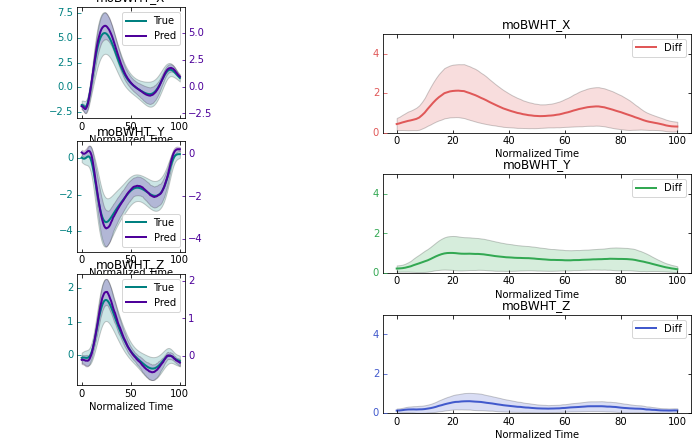

In [195]:
pp = PdfPages(join(targetDir,f"WHOLE_Total_result_{sess}.pdf"))
# # 축별 살제 예측은 한번에 그리고 에러는 밑에다 그리기
plt.figure(figsize=(10, 6))
meanStdPlot(321,[true_X.mean(axis=0),true_X.std(axis=0),pred_X.mean(axis=0),pred_X.std(axis=0)],f"{sess}_X")
diffPlot(322,[abs(true_X-pred_X).mean(axis=0),abs(true_X-pred_X).std(axis=0)],f"{sess}_X")
meanStdPlot(323,[true_Y.mean(axis=0),true_Y.std(axis=0),pred_Y.mean(axis=0),pred_Y.std(axis=0)],f"{sess}_Y")
diffPlot(324,[abs(true_Y-pred_Y).mean(axis=0),abs(true_Y-pred_Y).std(axis=0)],f"{sess}_Y")
meanStdPlot(325,[true_Z.mean(axis=0),true_Z.std(axis=0),pred_Z.mean(axis=0),pred_Z.std(axis=0)],f"{sess}_Z")
diffPlot(326,[abs(true_Z-pred_Z).mean(axis=0),abs(true_Z-pred_Z).std(axis=0)],f"{sess}_Z")
plt.tight_layout()
pp.savefig()
pp.close()